# License
Copyright (C) 2019 Christoph G. Hoffmann. All rights reserved.

This file is part of mjoindices

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program.  If not, see <https://www.gnu.org/licenses/>.

Contact: christoph.hoffmann@uni-greifswald.de

# Before you start
This example reproduces the original OMI values described in Kiladis, G.N., J. Dias, K.H. Straub, M.C. Wheeler, S.N. Tulich, K. Kikuchi, K.M. Weickmann, and M.J. Ventrice, 2014: A Comparison of OLR and Circulation-Based Indices for Tracking the MJO. Mon. Wea. Rev., 142, 1697–1715, https://doi.org/10.1175/MWR-D-13-00301.1

The script may run for about 2 hours on common desktop computers. <span style="color:red">The cells, which take most of the time, are commented in red</span>.

You can modify this example in order to compute OMI data from other OLR datasets (this is probably what you intend if you use this package). For this, you only have to provide your OLR data as a mjoindices.olr_handling.OLRData object and <span style="color:green"> inject it in two cells below, which are commented in green</span>.

This example also produces some diagnostic plots. More evalutation can be done afterwards with the included notebook evaluate_omi_reproduction.ipynb .



# Preparation of the recalculation
## Imports

In [15]:
from pathlib import Path
import os.path
import inspect

import mjoindices.olr_handling as olr
import mjoindices.omi.omi_calculator as omi
import mjoindices.empirical_orthogonal_functions as eof
import mjoindices.principal_components as pc
import mjoindices.evaluation_tools
import numpy as np

## Settings.
Adjust the settings and filenames according to your system here.



### DOY for Details
Select DOY for which you wuld like to seee a detailed comparison of the EOFs (number between 1 and 366)
E.g., DOY 23 is among the best agreements and DOY 218 the worst agreement.

In [16]:
doy=23

### Period, for which the PC time series are plotted
Select the start and end date.

In [17]:
pc_plot_period_start=np.datetime64("2011-01-01")
pc_plot_period_stop=np.datetime64("2011-12-31")


### External input files
**Original OLR data**: Download the data file from ftp://ftp.cdc.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc to your local file system and adjust the local path below.

In [18]:
olr_data_filename = Path(os.path.abspath('')).parents[0] / "tests" / "testdata" / "olr.day.mean.nc"

**Original EOF functions**: The following directory should contain the two subdirectories "eof1" and "eof2", which should contain the files downloaded from ftp://ftp.cdc.noaa.gov/Datasets.other/MJO/eof1/ and ftp://ftp.cdc.noaa.gov/Datasets.other/MJO/eof2/, respectively.

In [19]:
originalOMIDataDirname = Path(os.path.abspath('')).parents[0] / "tests" / "testdata" / "OriginalOMI"

**Original OMI PC values**: Download the original OMI values from https://www.esrl.noaa.gov/psd/mjo/mjoindex/omi.1x.txt to your local file system and adjust the local path below.

In [20]:
originalOMIPCFile = Path(os.path.abspath('')).parents[0] / "tests" / "testdata" / "OriginalOMI" / "omi.1x.txt"

### Recalculation output files

**The recalculated EOF values**:

In [21]:
eofnpzfile = Path(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))).parents[0] / "examples" / "example_data" / "EOFs.npz"

**The recalculated PC values**:

In [22]:
pctxtfile = Path(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))).parents[0] / "examples" / "example_data" / "PCs.txt"

**The directory in which the figures are saved**:

In [23]:
fig_dir = Path(os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))) / "example_data" / "omi_recalc_example_plots"
if not fig_dir.exists():
    fig_dir.mkdir(parents=True, exist_ok=False)

# Calculation of the EOFs

## Preparation of the OLR data

**Load** the original OLR data.

<span style="color:green">Note that this is the first of only two lines that have to be changed if you want to compute OMI for a different OLR dataset: Write a loader function for this dataset and replace the following line with a call of this function.</span>

In [24]:
raw_olr = olr.load_noaa_interpolated_olr(olr_data_filename)

Restrict dataset to the original length for the EOF calculation

In [25]:
shorter_olr = olr.restrict_time_coverage(raw_olr, np.datetime64('1979-01-01'), np.datetime64('2012-12-31'))

Make sure that the spatial sampling resembles the original one (This should not be necessary here, since we use the original data file. Nevertheless, we want to be sure.)

In [26]:
interpolated_olr = olr.interpolate_spatial_grid_to_original(shorter_olr)

**Diagnosis plot** of the loaded OLR data

/home/ch/mjoindices/venv_dist_test/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


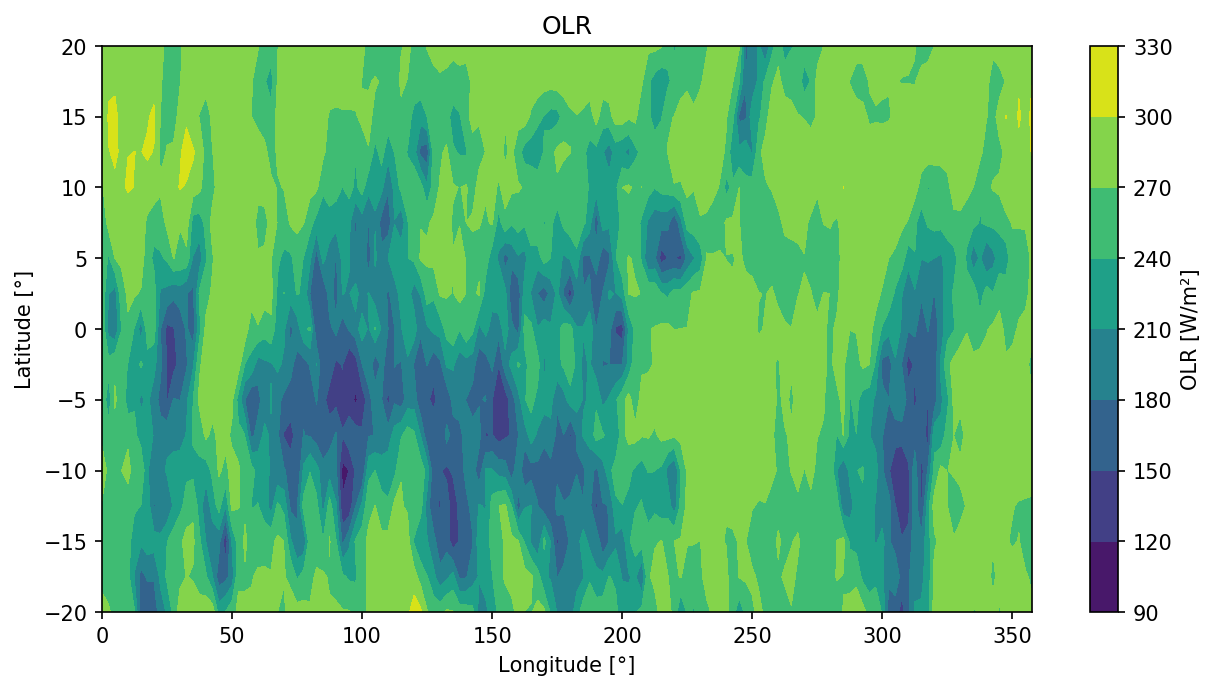

In [27]:
fig = olr.plot_olr_map_for_date(interpolated_olr, np.datetime64("2010-01-01"))
fig.show()
fig.savefig(fig_dir / "OLR_map.png")

# Calculation of the EOFs

Some details regarding the **calculation options**:

During the postprocessing, which is part of the recalculation, two optional steps can be execuated (see Kiladis, 2014, for details):
* The signs of the EOFs are adjusted (**sign_doy1reference**=True)
* The EOFs in a period around DOY 300 are replaced by an interpolation (**interpolate_eofs**=True)

The switch **strict_leap_year_treatment** has major implications only for the EOFs calculated for DOY 366 and causes only minor differences for the other DOYs. While the results for setting strict_leap_year_treatment=False are closer to the original values, the calculation strict_leap_year_treatment=True is somewhat more stringently implemented using built-in datetime functionality. See documentation of mjoindices.tools.find_doy_ranges_in_dates() for details.

<span style="color:red">This part takes most of the computation time.</span> Skip the following cell, if you have already computed and saved the EOFs before.

In [ ]:
eofs = omi.calc_eofs_from_olr(interpolated_olr,
                             sign_doy1reference=True,
                             interpolate_eofs=True,
                             strict_leap_year_treatment=True)
eofs.save_all_eofs_to_npzfile(eofnpzfile)

Smooth data temporally and longitudally...
Calculating for latitude:  -20.0
Calculating for latitude:  -17.5
Calculating for latitude:  -15.0
Calculating for latitude:  -12.5
Calculating for latitude:  -10.0
Calculating for latitude:  -7.5
Calculating for latitude:  -5.0
Calculating for latitude:  -2.5
Calculating for latitude:  0.0
Calculating for latitude:  2.5
Calculating for latitude:  5.0
Calculating for latitude:  7.5


# Evaluation of the EOFs

Load the original EOFs for comnparison.

Also load the recalculated EOFs from file first, just in case that they have not been recomputed during this session.

In [ ]:
orig_eofs = eof.load_all_original_eofs_from_directory(originalOMIDataDirname)
eofs = eof.restore_all_eofs_from_npzfile(eofnpzfile)

Check the **correlations and further statistics** between the EOFs for each DOY individually:

In [ ]:
fig = mjoindices.evaluation_tools.plot_comparison_stats_for_eofs_all_doys (eofs, orig_eofs, exclude_doy366=False, do_print=True)
fig.show()
fig.savefig(fig_dir / "EOFs_CorrelationWithOriginal.png")

Show the **explained variances** of the recalculation. Values are about a factor of 2. lower than in Kiladis, 2014, which is correct!

In [ ]:
fig = eof.plot_explained_variance_for_all_doys(eofs)
fig.show()
fig.savefig(fig_dir / "EOFs_ExplainedVariance.png")

Show a **detailed comparison of individual EOFs** for the particular DOY selected above

*Maps of EOF1 and EOF2:*

In [ ]:
fig = eof.plot_individual_eof_map(eofs.eofdata_for_doy(doy), doy)
fig.show()
fig.savefig(fig_dir / "EOF_Sample.png")

*Comparison of EOF maps*

In [ ]:
fig = mjoindices.evaluation_tools.plot_individual_eof_map_comparison(orig_eofs.eofdata_for_doy(doy), eofs.eofdata_for_doy(doy), doy)
fig.show()
fig.savefig(fig_dir / "EOF_SampleComparison.png")

*Explained variance for a specified number of Eigenvectors (default 10)*

The variance for EOF1 and EOF2 should be higher then for the other EOF numbers. The sum over all EOFs should be 1.0.

In [ ]:
fig = eof.plot_individual_explained_variance_all_eofs(eofs.eofdata_for_doy(doy), doy=doy, max_eof_number=10)
fig.show()
fig.savefig(fig_dir / "EOF_SampleExplainedVariance.png")

# Calculation of the PCs

Load the OLR data again, so that this section in independent of the EOF calculation.

<span style="color:green">Note that this is the second of only two lines that have to be changed if you want to compute OMI for a different OLR dataset: Write a loader function for this dataset and replace the following line with a call of this function.</span>

In [ ]:
olr = olr.load_noaa_interpolated_olr(olr_data_filename)

Load the EOFs, which have been calculated before (also to be independent of the previous cells)

In [ ]:
eofs = eof.restore_all_eofs_from_npzfile(eofnpzfile)

Calculate the PCs. Restrict calculation to the length of the original OMI time series.

<span style="color:red">This part may take several minutes on a common desktop computer.</span> Skip the following cell, if you have already computed and saved the PCs before.

In [ ]:
pcs = omi.calculate_pcs_from_olr(olr,
                                 eofs,
                                 np.datetime64("1979-01-01"),
                                 np.datetime64("2018-08-28"),
                                 useQuickTemporalFilter=False)
pcs.save_pcs_to_txt_file(pctxtfile)

# Evaluation of the PCs

Load the original PCs for comnparison.

Also load the recalculated PCs from file first, just in case that they have not been recomputed during this session.

In [ ]:
pcs = pc.load_pcs_from_txt_file(pctxtfile)
orig_pcs = pc.load_original_pcs_from_txt_file(originalOMIPCFile)

Plot sample period of the *PC time series*.

In [ ]:
fig = mjoindices.evaluation_tools.plot_comparison_orig_calc_pcs(pcs, orig_pcs, start_date=pc_plot_period_start, end_date=pc_plot_period_stop)
fig.savefig(fig_dir / "PCs_TimeSeries.png")
